In [76]:
import numpy as np
import astropy.io.fits as pyfits
import h5py
import pickle
import matplotlib.pyplot as plt
import scipy.optimize as op
from sklearn.cluster import DBSCAN
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/will/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov', 'slopes', 'scatter', 'f', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
phot_file = 'subfiles/UDS_DR11_photom_sub2_21.h5'
# load data
with h5py.File(phot_file, 'r') as f:
    x = np.array(f['x'].value)
    y = np.array(f['y'].value)
    ids = np.array(f['row_nums'].value)
ndata = y.shape[1]
flux = y[:int(y.shape[0]/2),:]
errs = y[int(y.shape[0]/2):,:]
nbands = flux.shape[0]

In [3]:
# remove objects with missing flux (later...)
print(np.min(flux, axis=1))

[   5.1915311     3.75325462    5.52912156    8.6202084    13.1713831
   16.76110322  -12.9937907    21.27339081   25.54876416   22.88138955
 -377.64840159 -282.61540919]


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,  3.,
         3.,  2.,  5.,  2.,  1.,  0.,  4.,  3.,  5.,  5.,  7., 18.,  7.,
        11.,  7., 11.,  8.,  9., 18., 10., 10.,  8., 18., 11., 14., 10.,
        12.,  5., 10.,  9., 12.,  9.,  6., 12.,  9., 10.,  6.,  4., 10.,
         3.,  3.,  5.,  5.,  6.,  4.,  4.,  4.,  3.,  7.,  2.,  5.,  2.,
         1.,  2.,  2.,  3.,  1.,  1.,  2.,  3.,  1.,  0.,  4.,  1.,  0.,
         2.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 8.6202084 ,  8.88990039,  9.15959237,  9.42928436,  9.69897634,
         9.96866833, 10.23836031, 10.5080523 , 10.77774428, 11.04743627,
        11.31712825, 11.58682024, 11.85651222, 12.12620421, 12.39589619,
        12.66558818, 12.93528017, 13.20497215, 13.47466414, 13.74435612,
        14.01404811, 14.28374009, 14.55343208, 14.82312406, 15.09281605,
        15.36250803, 15.63220002, 15.901892  , 16.17158399, 16.441275

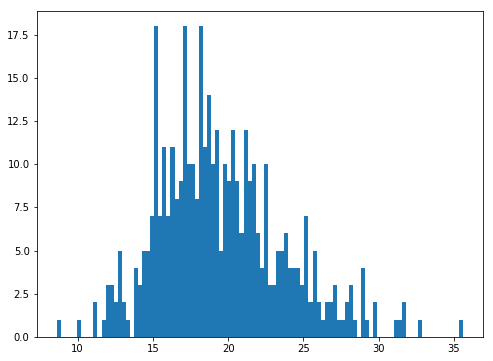

In [31]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(flux[3,:],bins=100)

In [4]:
wlen = np.array([3796.11571888, 4458.05618762, 5477.41955513, 6532.37444814, 7682.94106106, 9036.67456649, 10212.72604114, 12510.43831574, 16387.79389646, 22084.84812739, 35572.60440514, 44976.10885919])
flux.shape

(12, 411)

In [5]:
stddev = np.std(flux, axis=1)
mean = np.average(flux, axis=1)
print(mean)
print(stddev)
cov_pred = np.outer(stddev,stddev)

[10.97315067 13.18640236 15.21543371 19.51275989 29.01377586 38.51316867
 50.16230484 49.55721555 55.23171061 63.83391544 35.32279587 19.84806005]
[ 3.00926069  2.68742976  2.83998894  4.18924478  6.2603819   8.59759876
 16.53880675 12.70756439 14.99821356 15.20885092 47.31457827 51.93783403]


In [6]:
# Some of the stddev is just amplitude differences - compute the covariance
cov = np.cov(flux)
print(cov.shape)


(12, 12)


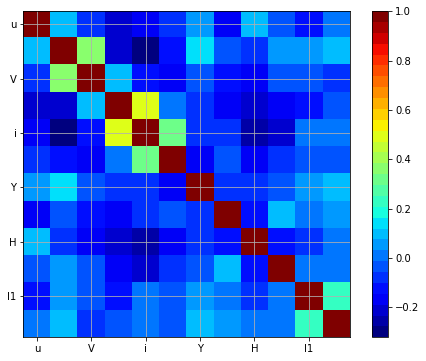

In [7]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
cmap = plt.cm.get_cmap('jet', 30)
cax = ax1.imshow(cov / cov_pred, interpolation="nearest", cmap=cmap)
#labels = x[::4] # don't know why it skips the first one...
labels = ['dumbshit plotting', 'u', 'V', 'i', 'Y', 'H', 'I1']
ax1.set_xticklabels(labels)
ax1.set_yticklabels(labels)
fig.colorbar(cax)
ax1.grid(True)

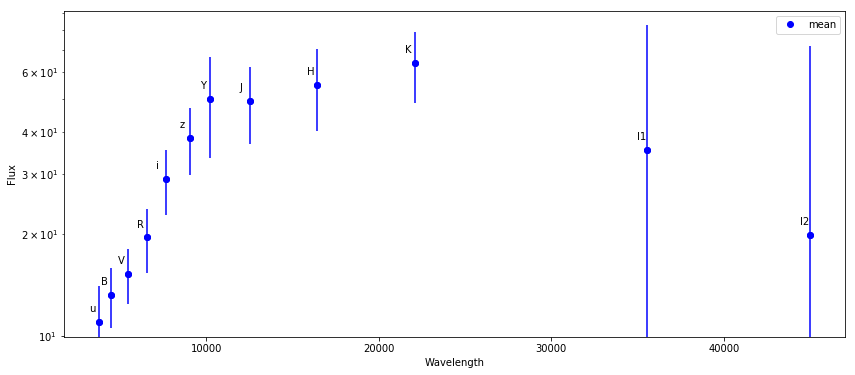

In [8]:
labels = ['u', 'B', 'V', 'R', 'i', 'z', 'Y', 'J', 'H', 'K', 'I1', 'I2']
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.plot(wlen,mean,'o',label='mean',c='blue')
ax.errorbar(wlen,mean,yerr=stddev,c='blue',fmt='o')
#ax.plot(wlen+5.,ypred,'o',label='model',c='red')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_yscale('log')
for i,j,k in zip(wlen,mean,labels):
    ax.annotate('%s' %k, xy=(i,j), xytext=(-10,10), textcoords='offset points')
ax.legend()

In [9]:
# What does the correlation matrix look like if objects are just different in amplitude,
# with noise?
iobj = 320
sig_amp = 10. # this is the stddev of amplitudes
n_samp = 300
print(np.average(errs[:,iobj]/flux[:,iobj]))
print(np.argmin(np.average(errs/flux, axis=0)**2))

0.11132243204549512
371


In [10]:
fake_data = np.tile(flux[:,iobj], n_samp).reshape(n_samp, flux.shape[0]).T
err_cube = np.tile(errs[:,iobj], n_samp).reshape(n_samp, flux.shape[0]).T * \
            np.random.normal(size=(fake_data.shape)) * \
            ((np.random.normal(size=(fake_data.shape)) * sig_amp) + 1.)
fake_data += err_cube
print(fake_data.shape)

(12, 300)


In [11]:
stddev_test = np.std(fake_data, axis=1)
mean_test = np.average(fake_data, axis=1)
cov_pred_test = np.outer(stddev_test,stddev_test)
cov_test = np.cov(fake_data)

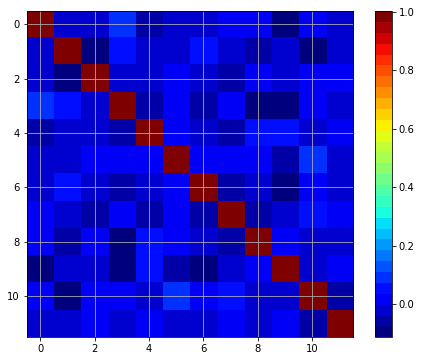

In [12]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
cmap = plt.cm.get_cmap('jet', 30)
cax = ax1.imshow(cov_test / cov_pred_test, interpolation="nearest", cmap=cmap)
fig.colorbar(cax)
ax1.grid(True)

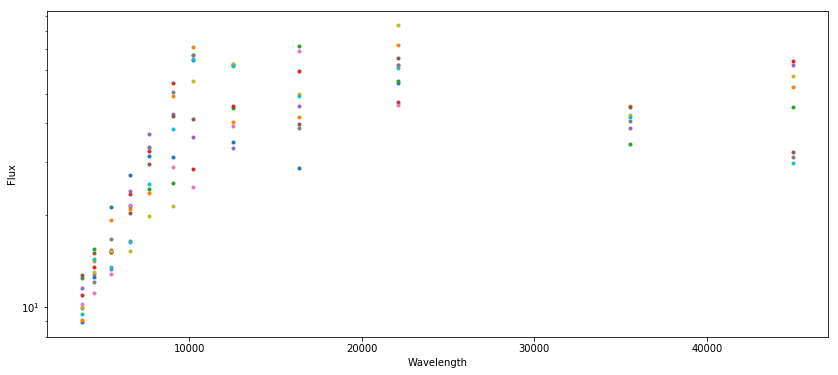

In [13]:
obs = np.random.sample(10) * flux.shape[1]
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
for ob in obs:
    ax.plot(wlen,flux[:,int(ob)],'.')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_yscale('log')

In [14]:
# Ranking objects
# fit a simple slope across B -> K
# log(flux) = a * wlen + b
# http://dfm.io/emcee/current/user/line/
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


In [15]:
mask = np.where(flux[:,int(ob)]>0.)[0]
x = wlen[mask]
y = np.log(flux[:,int(ob)][mask])
yerr = np.log((flux[:,int(ob)][mask]+errs[:,int(ob)][mask])/flux[:,int(ob)][mask])

In [66]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1e-6, 3., np.log(0.01)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [67]:
m_ml

0.00015024957666147042

In [79]:
slopes = np.zeros((ndata))
intercepts = np.zeros((ndata))
scatter = np.zeros((ndata))

In [80]:
for ob in range(ndata):
    mask = np.where(flux[:10,int(ob)]>0.)[0]
    x = wlen[mask]
    y = np.log(flux[:,int(ob)][mask])
    yerr = np.log((flux[:,int(ob)][mask]+errs[:,int(ob)][mask])/flux[:,int(ob)][mask])
    
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [1e-4, 10., np.log(0.1)], args=(x, y, yerr))
    slopes[ob], intercepts[ob], scatter[ob] = result["x"]
    

In [81]:
#print(slopes,intercepts)

Text(0,0.5,'intercepts')

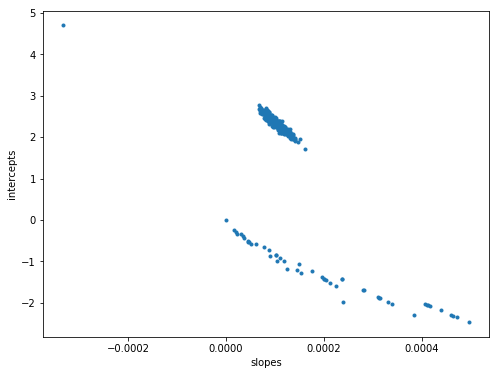

In [82]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(slopes,intercepts,'.')
ax.set_xlabel('slopes')
ax.set_ylabel('intercepts')
#ax.set_xscale('log')
#ax.set_ylim([1.6,3.])
#ax.set_xlim([6e-5,2e-4])

0.0004960004570458263 -2.46171930244908 312


/home/will/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/will/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


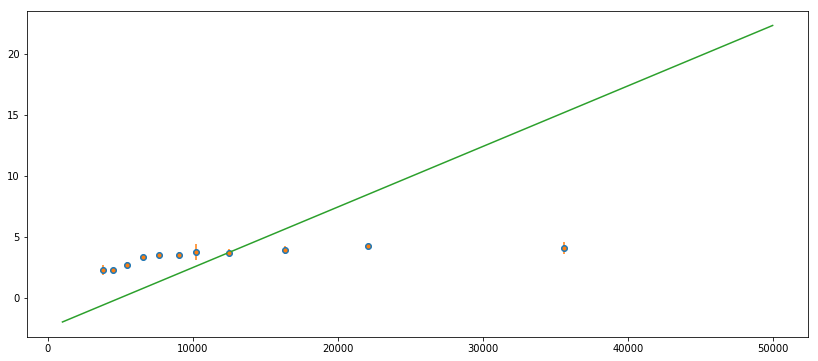

In [83]:
ob = np.argmin(intercepts)
#ob = 100
xarr = np.linspace(1000.,50000.,10)
print(slopes[int(ob)], intercepts[int(ob)], ob)
yarr = xarr * slopes[int(ob)] + intercepts[int(ob)]
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.plot(wlen, np.log(flux[:,int(ob)]),'o')
ax.errorbar(wlen, np.log(flux[:,int(ob)]),yerr=np.log((flux[:,int(ob)]+errs[:,int(ob)])/flux[:,int(ob)]), fmt='.')
ax.plot(xarr,yarr)

In [85]:
print(np.vstack((intercepts,slopes)).T.shape)
db = DBSCAN(eps=0.3, min_samples=10).fit(np.vstack((intercepts,slopes)).T)

(411, 2)


(-1e-05, 0.0003)

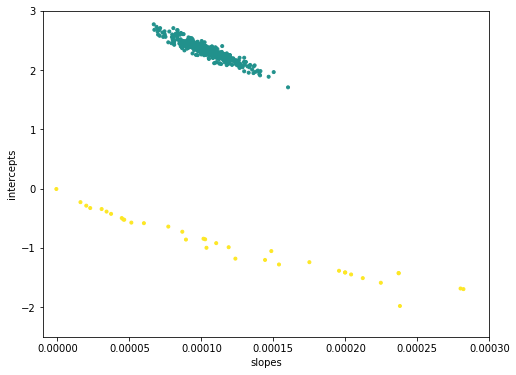

In [92]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(slopes,intercepts,marker='.',c=db.labels_)
ax.set_xlabel('slopes')
ax.set_ylabel('intercepts')
#ax.set_xscale('log')
ax.set_ylim([-2.5,3.])
ax.set_xlim([-1e-5,3e-4])

In [103]:
clusters = np.unique(db.labels_)
print(clusters)
counts = np.zeros_like(clusters)
for i,group in enumerate(clusters):
    counts[i] = len(db.labels_[db.labels_==group])
print(counts)

[-1  0  1]
[  1 359  51]


In [106]:
keep_obs = np.where(db.labels_==clusters[np.argmax(counts)])

(5e-05, 0.00017)

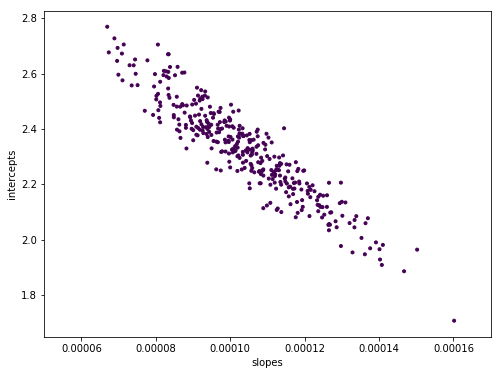

In [112]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(slopes[keep_obs],intercepts[keep_obs],marker='.',c=db.labels_[keep_obs])
ax.set_xlabel('slopes')
ax.set_ylabel('intercepts')
#ax.set_ylim([-2.5,3.])
ax.set_xlim([5e-5,1.7e-4])